<a href="https://colab.research.google.com/github/DavidkingMazimpaka/Stroke_Analysis_and_Prediction/blob/main/strokeAnalysisPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Stroke Analysis and Prediction

In [44]:
# Importing all necessary libraries
# for visulization
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
import seaborn as sns
from scipy import stats
# for modeling
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold , StratifiedKFold , cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# loadin' the dataset
data = pd.read_csv("/content/healthcare-dataset-stroke-data.csv")

In [16]:
data=data.drop(columns="id")

In [17]:
indices = data[data.isna().any(axis=1)].index
data[data.isna().any(axis=1)]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


In [18]:
data["age_group"]=data["age"].apply(lambda x:"Infant" if (x>=0)&(x<=2)
                                  else ("Child" if (x>2)&(x<=12)
                                  else ("Adolescent"if (x>12)&(x<=18)
                                  else ("Young Adults"if (x>19)&(x<=35)
                                  else ("Middle Aged Adults" if (x>35)&(x<=60)
                                  else "Old Aged Adults")))))

In [19]:
data.groupby(["gender","ever_married","age_group"])["bmi"].mean()

gender  ever_married  age_group         
Female  No            Adolescent            26.207558
                      Child                 19.534225
                      Infant                18.346341
                      Middle Aged Adults    30.200820
                      Old Aged Adults       29.691111
                      Young Adults          28.134084
        Yes           Middle Aged Adults    31.517157
                      Old Aged Adults       29.672853
                      Young Adults          30.543919
Male    No            Adolescent            25.529730
                      Child                 19.777523
                      Infant                18.988506
                      Middle Aged Adults    31.925352
                      Old Aged Adults       28.805882
                      Young Adults          28.603636
        Yes           Adolescent            27.400000
                      Middle Aged Adults    31.969624
                      Old Aged Adults       29.967442
                      Young Adults          29.938636
Other   No            Young Adults          22.400000
Name: bmi, dtype: float64

## Cleaning up the na values using mean by gender,ever_married and age group

In [20]:
data['bmi'] = data['bmi'].fillna(data.groupby(["gender","ever_married","age_group"])["bmi"].transform('mean'))

In [21]:
data.iloc[indices,:]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_group
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.672853,never smoked,1,Old Aged Adults
8,Female,59.0,0,0,Yes,Private,Rural,76.15,31.517157,Unknown,1,Middle Aged Adults
13,Male,78.0,0,1,Yes,Private,Urban,219.84,29.967442,Unknown,1,Old Aged Adults
19,Male,57.0,0,1,No,Govt_job,Urban,217.08,31.925352,Unknown,1,Middle Aged Adults
27,Male,58.0,0,0,Yes,Private,Rural,189.84,31.969624,Unknown,1,Middle Aged Adults
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,Male,41.0,0,0,No,Private,Rural,70.15,31.925352,formerly smoked,0,Middle Aged Adults
5048,Male,40.0,0,0,Yes,Private,Urban,191.15,31.969624,smokes,0,Middle Aged Adults
5093,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.517157,smokes,0,Middle Aged Adults
5099,Male,40.0,0,0,Yes,Private,Rural,83.94,31.969624,smokes,0,Middle Aged Adults


In [23]:
data = data[(data["bmi"]<66) & (data["bmi"]>12)]

In [24]:
data=data.drop(data[data["gender"]=="Other"].index)

## Average BMI of people who had a stroke vs those who hasn't

In [28]:
data.groupby("stroke")["bmi"].mean()

,bmi
stroke,
0,28.802117
1,30.382560


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

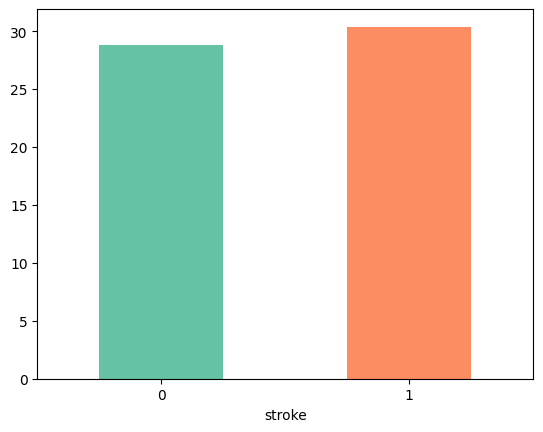

In [29]:
data.groupby("stroke")["bmi"].mean().plot(kind="bar",color =sns.color_palette("Set2"))
plt.xticks(rotation=0)

**Mostly the same with a slight increase in those who had a stroke at 30.3 vs those who hasn't at 28.8**

## Correlation between data attributes

In [30]:
corr_data =data.copy()
encoder  =LabelEncoder()
for col in corr_data.select_dtypes(include="object").columns:
    corr_data[col] =encoder.fit_transform(corr_data[col])

<Axes: >

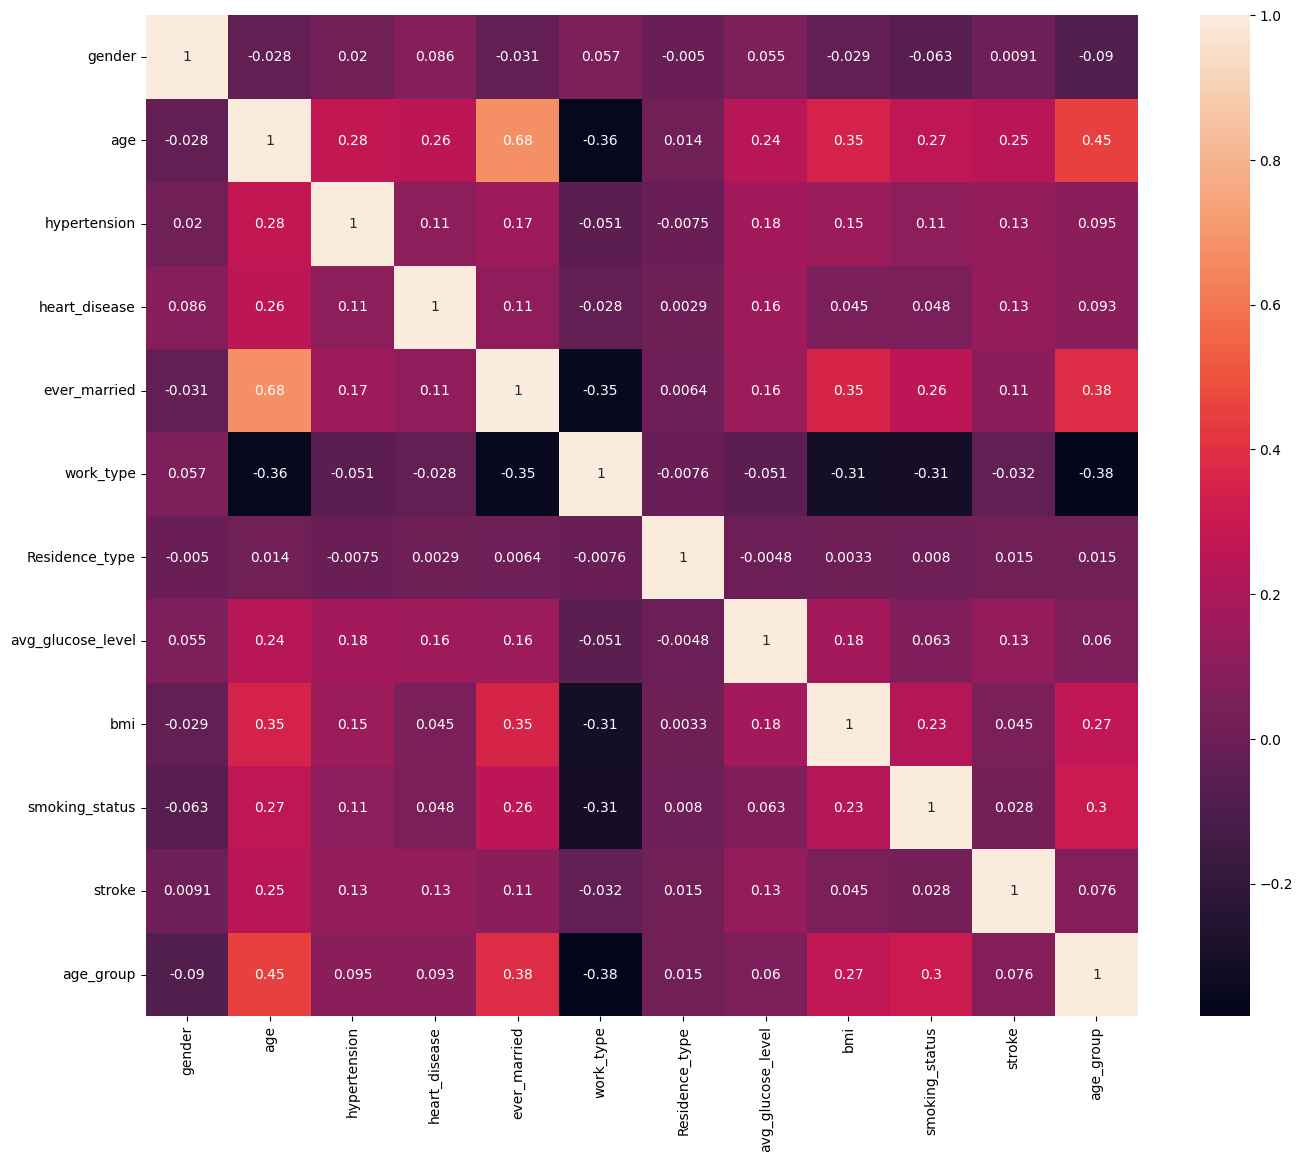

In [31]:
plt.figure(figsize=(16,13))
sns.heatmap(data=corr_data.corr(),annot=True)

## Upsampling the data for class Imbalance

In [34]:
had_stroke = data[data["stroke"]==1]
no_stroke = data[data["stroke"]==0]
upsampled_had_stroke = resample(had_stroke,replace=True , n_samples=no_stroke.shape[0] , random_state=123 )
upsampled_data = pd.concat([no_stroke,upsampled_had_stroke])

<Axes: ylabel='count'>

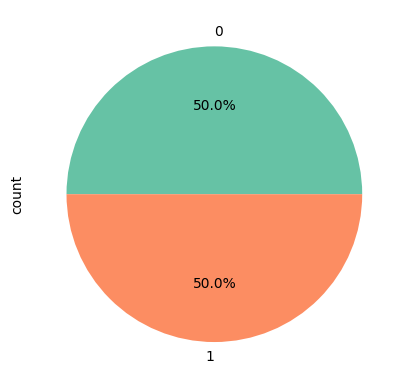

In [35]:
upsampled_data.stroke.value_counts().plot(kind = "pie",autopct="%0.1f%%",colors =sns.color_palette("Set2"))

In [36]:
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'age_group'],
      dtype='object')

# Encoding nominal data using pd dummies and ordinal using label encode

In [37]:
cols = ['gender','hypertension','heart_disease', 'ever_married', 'work_type', 'Residence_type','smoking_status']
dums = pd.get_dummies(upsampled_data[cols],dtype=int)
model_data = pd.concat([upsampled_data,dums],axis=1).drop(columns=cols)

In [38]:
encoder = LabelEncoder()
model_data["age_group"] = encoder.fit_transform(model_data["age_group"])

## Normalizing the data using min max scaler

In [39]:
scaler = MinMaxScaler()
for col in ['age','avg_glucose_level','bmi']:
    scaler.fit(model_data[[col]])
    model_data[col]=scaler.transform(model_data[[col]])
model_data

,age,avg_glucose_level,bmi,stroke,age_group,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
249,0.035645,0.184655,0.108571,0,1,0,1,1,0,0,0,0,0,1,1,0,1,0,0,0
250,0.707031,0.151602,0.512381,0,3,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0
251,0.096680,0.257455,0.100952,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0
252,0.853516,0.064260,0.449524,0,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
253,0.169922,0.490075,0.129524,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0.670410,0.716831,0.527619,1,3,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
26,0.792480,0.211707,0.302857,1,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
122,0.975586,0.944096,0.369524,1,4,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1
168,0.963379,0.198043,0.190476,1,4,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0


## Modeling
## Splitting the data and initialzing models

In [40]:
X = model_data.drop(columns="stroke")
y = model_data["stroke"]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=7,shuffle=True)

In [45]:
etc_model = ExtraTreesClassifier()
rfc_model = RandomForestClassifier(n_estimators=29,max_leaf_nodes=900,max_features=0.8,criterion="entropy")
xgb_model = XGBClassifier(objective="binary:logistic",eval_metric = "auc")
gbc_model = GradientBoostingClassifier(max_depth=29,min_samples_leaf=4,min_samples_split=13,subsample=0.8)

models = [etc_model,rfc_model,xgb_model,gbc_model]

# Training and Evaluating Different Models

In [46]:
for model in models:
    model.fit(X_train,y_train)

In [47]:
for model in models:
    model_name = type(model).__name__
    print(f"score for {model_name} on train data: {model.score(X_train,y_train)}")

score for ExtraTreesClassifier on train data: 1.0
score for RandomForestClassifier on train data: 1.0
score for XGBClassifier on train data: 0.9966499162479062
score for GradientBoostingClassifier on train data: 1.0


In [48]:
for model in models:
    model_name = type(model).__name__
    print(f"score for {model_name} on test data: {model.score(X_test,y_test)}")

score for ExtraTreesClassifier on test data: 0.9917568263781555
score for RandomForestClassifier on test data: 0.9835136527563112
score for XGBClassifier on test data: 0.9685729005667182
score for GradientBoostingClassifier on test data: 0.9866048428645028


# Classification report for each model


---


 **This is for better understanding how
each model and the accuracy**

In [49]:
for model in models:
    y_predicted = model.predict(X_test)
    model_name = type(model).__name__
    print(f"Report:{model_name}")
    print(classification_report(y_test,y_predicted))

Report:ExtraTreesClassifier
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       994
           1       0.98      1.00      0.99       947

    accuracy                           0.99      1941
   macro avg       0.99      0.99      0.99      1941
weighted avg       0.99      0.99      0.99      1941

Report:RandomForestClassifier
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       994
           1       0.97      1.00      0.98       947

    accuracy                           0.98      1941
   macro avg       0.98      0.98      0.98      1941
weighted avg       0.98      0.98      0.98      1941

Report:XGBClassifier
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       994
           1       0.94      1.00      0.97       947

    accuracy                           0.97      1941
   macro avg       0.97      0.97      0.97      

Let's try Model Validation using *K-fold Cross Validation*

In [50]:
print("scores of each model using kfold validation:-\n\n")
for model in models:
    score = cross_val_score(model,X,y,cv=10)
    avg = np.mean(score)
    model_name = type(model).__name__
    print(f"scores for {model_name}:{score}")
    print(f"average score for {model_name}:{avg}\n")

scores of each model using kfold validation:-


scores for ExtraTreesClassifier:[0.99176107 0.99485067 0.98762887 0.99278351 0.99175258 0.99278351
 0.99690722 0.99484536 0.99587629 0.99793814]
average score for ExtraTreesClassifier:0.9937127204391263

scores for RandomForestClassifier:[0.98146241 0.98764161 0.98453608 0.98865979 0.98041237 0.98865979
 0.98865979 0.99072165 0.98969072 0.9814433 ]
average score for RandomForestClassifier:0.9861887521632496

scores for XGBClassifier:[0.96910402 0.96704428 0.97113402 0.9814433  0.9628866  0.97731959
 0.97938144 0.9742268  0.97938144 0.97113402]
average score for XGBClassifier:0.9733055517215752

scores for GradientBoostingClassifier:[0.98970134 0.98867147 0.98865979 0.99072165 0.98453608 0.99072165
 0.99175258 0.99278351 0.99381443 0.98556701]
average score for GradientBoostingClassifier:0.9896929512565429



## Finally lets compute the **Confusion Matrice for the models**

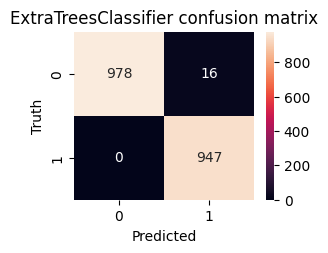

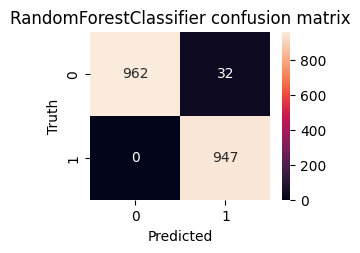

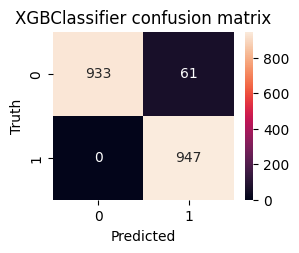

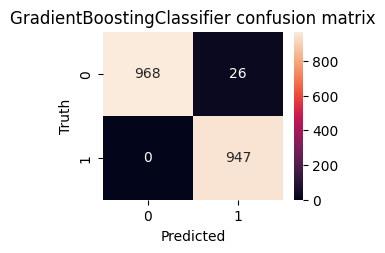

In [51]:
for i,model in enumerate(models):
    plt.subplot(2,2,i+1)
    y_predicted = model.predict(X_test)
    model_name = type(model).__name__
    cm = confusion_matrix(y_test, y_predicted)
    sns.heatmap(cm, annot=True,fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title(f"{model_name} confusion matrix")
    plt.show()

**Saving the model**


### **Conclusion**


---


* The best model was Extra Trees Classifier followed by Gradient boosting , Random Forest and XGboost
* Accuracy for Extra Trees was 99% and average cross validtation score of 99%
* Accuracy for Random Forest was 98% and average cross validtation score of 98%
* Accuracy for XGboost was 98% and average cross validtation score of 97%
* Accuracy for Gradient Boost was 98% and average cross validtation score of 98%

In [52]:
import pickle

MODEL_OPT_FILE = 'strokePredict.pkl'
with open(MODEL_OPT_FILE, 'wb') as file:
    pickle.dump(model, file)

In [53]:
from google.colab import files

files.download(MODEL_OPT_FILE)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>